In [30]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh

In [1]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [2]:
s  = ctl.TransferFunction.s

G = 12/((s-10)*(s+5))
#G = (s+20)/(s*(s+2)*(s+3))

G

NameError: name 'ctl' is not defined

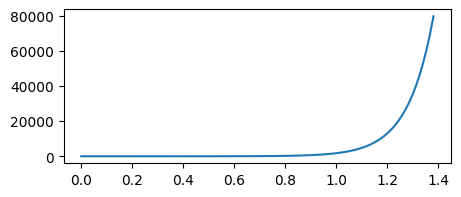

In [33]:
time, response = ctl.step_response(G)
plt.figure(figsize=(5, 2))
plt.plot(time, response)

- Encontrando as características da resposta transitória e permanente

In [34]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  79999.76015999969
tempo de pico:  1.3815510557964275
tempo de assentamento:  None
valor final:  79999.76015999969
erro:  79998.76015999969


- Encontrando os polos do sistema

In [35]:
polos = ctl.pole(G)
zeros = ctl.zeros(G)

display(sp.Matrix(polos))
display(sp.Matrix(zeros))

Matrix([
[10.0],
[-5.0]])

Matrix(0, 1, [])

# ENCONTRANDO OS PARÂMETROS DESEJADOS
- O primeiro parâmetero é que o erro seja nulo, ou seja $c(\infty) = \lim_{t \to \infty} c(t) = \lim_{s \to 0} s\,C(s) = \lim_{s \to 0} s\,G(s)R(s)= 0$

- O segundo parâmetro se refere à resposta transitória do sistema, ou seja, queremos alguma informação da resposta transitória que nos dê $\zeta$. Um bom parâmetro é o tempo de estabilização $T_s$, gostaria que $T_s$ fosse pequeno.

$T_s = \frac{4}{\zeta\omega_n}$


In [36]:
Ts = 5
UP = 0.5

In [37]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.2154537619662468

In [38]:
Wn = 4/(zeta*Ts)
Wn

3.713093671232015

# ROOT LOCUS
Uma maneira de encontrar o polo desejado $s_D$ para o controlador é encontrando a interseção da linha vertical projetada por $\zeta$ com o caminho percorrido pelo LGR. O root locus nos dá uma informação importante sobre como é possível controlar o sistema, mostrando o caminho pelo qual os polos e zeros podem percorrer para chegar em uma estabilidade, ou seja, no semiplano esquerdo

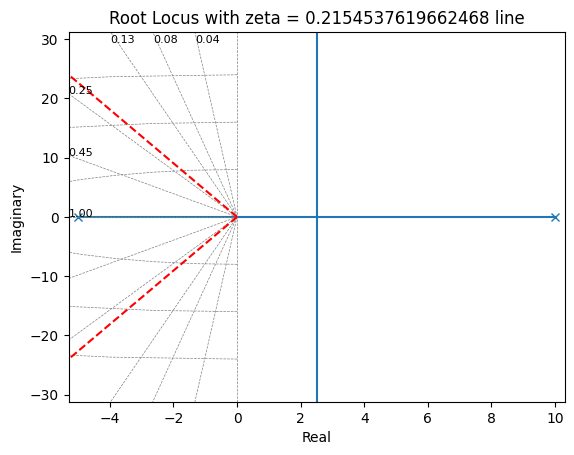

In [39]:
def zGrid(G, zeta):
    ctl.root_locus(G)

    angle  = np.arccos(zeta)
    radius = np.linspace(0, 100, 400)

    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    
    plt.plot(-x, y, 'r--')
    plt.plot(-x, -y, 'r--')

    plt.title(f'Root Locus with zeta = {zeta} line')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()

zGrid(G, zeta)

$s = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [40]:
s_desired = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_desired

-0.8 + 3.62588811346175*I

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\frac{(s-a)(s-b)}{s(s+p)}$

- $p$ é um polo colocado arbitrariamente pois o número de polos tem que ser maior ou igual o número de zeros, para que seja possível implementá-lo digitalmente, com uma função de transferência própria. Esse polo $p$ precisa estar longe do eixo imaginário para que tenha pouca influência no sistema

In [41]:
s = sp.symbols('s')
K, a, b = sp.symbols('K a b', real=True)

- A função de transferência final em malha aberta será $G(s)C(s)$

In [42]:
C     = K * ((s + a) * (s + b)) / (s * (s + 20))
C_bkp = str(C)

C

K*(a + s)*(b + s)/(s*(s + 20))

In [43]:
GC = sympyFunction(G) * C
GC

12*K*(a + s)*(b + s)/(s*(s + 20)*(s**2 - 5*s - 50))

In [44]:
ZERO = 1e-10

- Erro em regime permanente para entrada em degrau é igual a zero (malha fechada)

- $erro = \frac{1}{1+K_p}$ onde $K_p = \lim_{s\to 0} G(s)$

In [45]:
Kp  = GC.subs(s, ZERO).expand().simplify()
eq1 = 1/(1 + Kp)
eq1 = roundSympyFunction(eq1)

eq1 = sp.Eq(eq1, ZERO)
eq1

Eq(1/(K*(-119999999.9982*a*b - 0.012*a - 0.012*b) + 1), 1.0e-10)

- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [46]:
G_aux = GC.subs(s, s_desired)
angle = sp.arg(G_aux)
angle = roundSympyFunction(angle)

eq2 = sp.Eq(angle + sp.pi, ZERO)
eq2

Eq(arg(-K*(0.8 + 3.625888*I)*(19.2 - 3.625888*I)*(a - 0.8 + 3.625888*I)*(b - 0.8 + 3.625888*I)/(-46.0 - 18.129441*I + (-0.8 + 3.625888*I)**2)) + pi, 1.0e-10)

- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [47]:
G_aux  = GC.subs(s, s_desired)
modulo = sp.Abs(G_aux).expand().simplify()
modulo = roundSympyFunction(modulo)

eq3    = sp.Eq(modulo - 1, ZERO)
eq3

Eq(0.036075*sqrt(0.072532*a**2 - 0.116051*a + 1)*sqrt(0.072532*b**2 - 0.116051*b + 1)*Abs(K) - 1, 1.0e-10)

In [48]:
def convertString(eq):
    substitutions = {
        'sqrt': 'np.sqrt',
        'Abs' : 'np.abs',
        'pi'  : 'np.pi',
        'arg' : 'np.angle',
        '*I'  : 'j',
        'I)'  : '1j)'
    }

    result = str(eq.lhs)
    for key, value in substitutions.items():
        result = result.replace(key, value)

    return result

str_eq1 = convertString(eq1)
str_eq2 = convertString(eq2)
str_eq3 = convertString(eq3)

print(str_eq1)
print(str_eq2)
print(str_eq3)

1/(K*(-119999999.9982*a*b - 0.012*a - 0.012*b) + 1)
np.angle(-K*(0.8 + 3.625888j)*(19.2 - 3.625888j)*(a - 0.8 + 3.625888j)*(b - 0.8 + 3.625888j)/(-46.0 - 18.129441j + (-0.8 + 3.625888j)**2)) + np.pi
0.036075*np.sqrt(0.072532*a**2 - 0.116051*a + 1)*np.sqrt(0.072532*b**2 - 0.116051*b + 1)*np.abs(K) - 1


In [49]:
def sistema(variaveis):
    (K, a, b) = variaveis
    return [
        eval(str_eq1), 
        eval(str_eq2),
        eval(str_eq3)
    ]

guess = [1, 1, 1]
solutions = fsolve(sistema, guess, maxfev=10000000, xtol=ZERO)
print('Solucoes:', solutions, '\n')

Solucoes: [24.79124038  2.05770147  2.52851254] 



/home/klauss/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [50]:
for eq in [eq1, eq2, eq3]:
    sol = eq.lhs.subs({
        K: solutions[0],
        a: solutions[1],
        b: solutions[2]
    })
    print(sp.N(sol))

-6.46060243968387e-11
1.33240178709863e-8
1.72839013323767e-7


In [51]:
K = solutions[0]
a = solutions[1]
b = solutions[2]

- Função de transferência do controlador $C(s)$

In [52]:
s = ctl.TransferFunction.s
C = eval(C_bkp)

print(sympyFunction(C))
C

(24.7912403814571*s**2 + 113.697934061576*s + 128.986939082881)/(s**2 + 20*s)


TransferFunction(array([ 24.79124038, 113.69793406, 128.98693908]), array([ 1, 20,  0]))

- Função de transferência do sistema em malha aberta $C(s)G(s)$

In [53]:
GC = G*C
GC

TransferFunction(array([ 297.49488458, 1364.37520874, 1547.84326899]), array([    1,    15,  -150, -1000,     0]))

- Função de transferência em malha fechada com realimentação unitária $G_{feedback}(s) = \frac{G(s)C(s)}{1+G(s)C(s)}$

In [54]:
G_feedback = ctl.feedback(GC, 1)
G_feedback

TransferFunction(array([ 297.49488458, 1364.37520874, 1547.84326899]), array([1.00000000e+00, 1.50000000e+01, 1.47494885e+02, 3.64375209e+02,
       1.54784327e+03]))

In [55]:
ctl.poles(G_feedback)

array([-6.69999959+8.20839928j, -6.69999959-8.20839928j,
       -0.80000041+3.62588762j, -0.80000041-3.62588762j])

# APLICANDO UM STEP

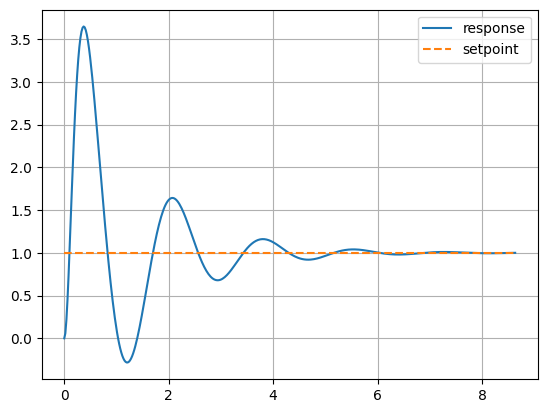

In [56]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, label='response')
plt.plot(time, [1 for i in time], '--', label='setpoint')
plt.legend()
plt.grid()

In [57]:
getAllInfo(time, response, setpoint=1)

overshoot:  2.647931690160533
valor de pico:  3.64817648001746
tempo de pico:  0.370941322704215
tempo de assentamento:  5.873237609483404
valor final:  1.0000671037392468
erro:  6.71037392467877e-05


# APLICANDO VÁRIOS STEPS

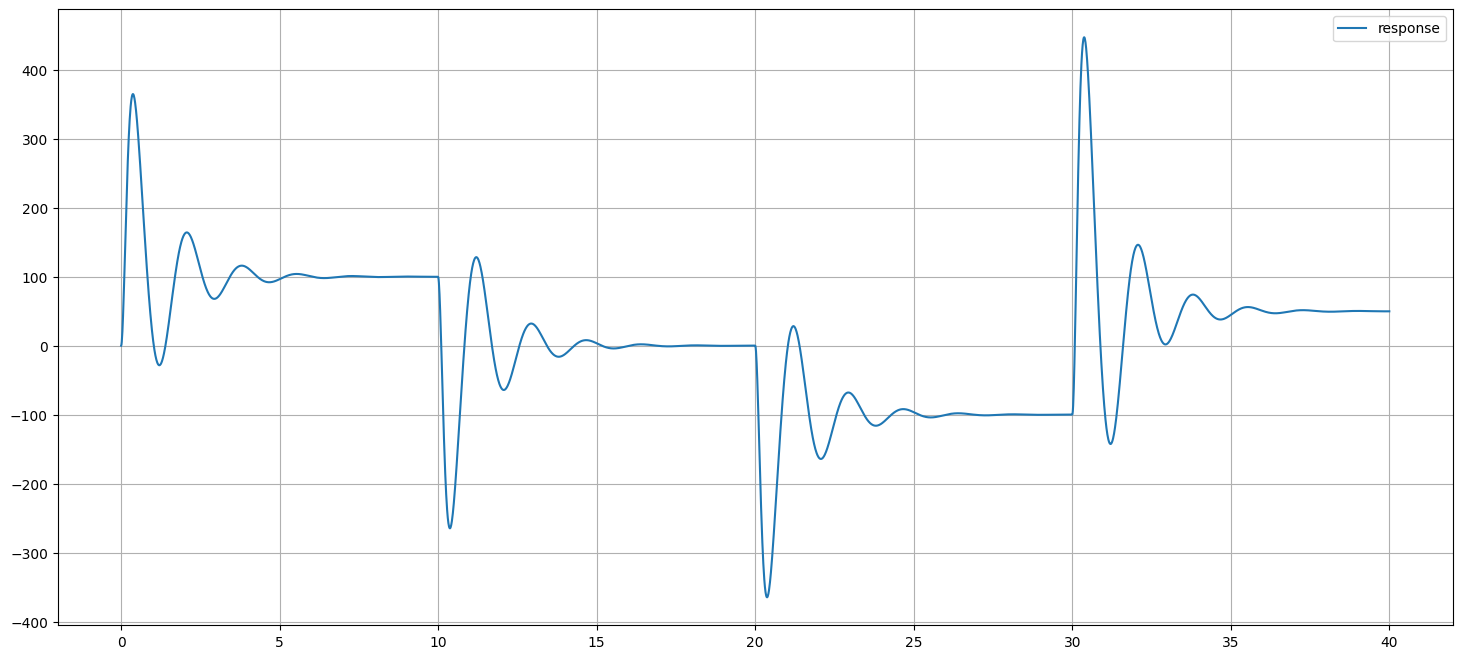

In [58]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()